# Configuration

In [1]:
# Set test subject (use the actual #, not the index)
subject_number = 1

# Set the percentage of each subject's data to use for training. 1 = 100%)
subject_data_percentage = 0.2

# Sequence Length (in seconds)
sequence_length = .03

# Set the predictive horizon (in seconds)
predictive_horizon = 1

# Amount of data to skip at the beginning of each subject's data
start_skip = 1000 # 10 second

# Set feature and target columns
feat_cols = ['Pressure [cmH2O]', 'V_tidal [L]', 'Flow [L/s]']
target_cols = ['Flow [L/s]']

assert subject_number > 0, "Subject number must be greater than 0."
assert subject_data_percentage > 0, "Subject data percentage must be greater than 0."
assert predictive_horizon > 0, "Predictive horizon must be greater than 0."
assert sequence_length > 0, "Sequence length must be greater than 0."
assert len(feat_cols) > 0, "Feature columns must not be empty."
assert len(target_cols) > 0, "Target columns must not be empty."

# Setup

In [2]:
# Imports
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [3]:
# Constants
sequence_length = int(sequence_length * 100)
predictive_horizon = predictive_horizon * 100

# Data Prep

### Import Data

In [4]:
# Read in files
files = glob.glob('data/ProcessedData_Subject*.csv')

data_dfs = []

for filepath in files:
    df = pd.read_csv(filepath)
    
    # Extract subject number from path
    current_subject_number = filepath.split('/')[-1].split('_Subject')[1].split('.')[0].lstrip('0')
    df['Subject Number'] = current_subject_number
    data_dfs.append(df)
    
# Check
#data_dfs[0].head()

### Clean Data

In [5]:
def remove_outliers(df, columns):
    z_scores = np.abs(stats.zscore(df[columns]))
    filtered_entries = (z_scores < 4).all(axis=1)  # Relaxing the threshold to 4
    return df[filtered_entries]

def standardize(df, columns):
    scaler = StandardScaler()
    df.loc[:, columns] = scaler.fit_transform(df[columns])
    return df

processed_data_dfs = []

for subject_df in data_dfs:

    # Fill missing values with forward fill
    subject_df.ffill(inplace=True)

    subject_df_clean = remove_outliers(subject_df, feat_cols)

    subject_df_standardized = standardize(subject_df_clean, feat_cols)

    processed_data_dfs.append(subject_df_standardized)

# Check
#processed_data_dfs[3].head()

### Prepare Subsets

In [6]:
subset_data_dfs = []

for subject_df in processed_data_dfs:

    size = int(len(subject_df) * subject_data_percentage)

    # Skipping the first start_skip rows
    subset_df = subject_df.iloc[start_skip:start_skip + size]

    subset_data_dfs.append(subset_df)

test_subject_df = subset_data_dfs[subject_number - 1]

# Generate Sequences

In [7]:
# Parameters
sequence_arrays = []
target_arrays = []

test_sequence_arrays = []
test_target_arrays = []

for subject_df in subset_data_dfs:
    for i in range(0, len(subject_df) - sequence_length - predictive_horizon):
        sequence_array = subject_df.iloc[i:i + sequence_length][feat_cols].values
        target_array = subject_df.iloc[i + sequence_length + predictive_horizon][target_cols].iloc[0]
        if subject_df['Subject Number'].iloc[0] == str(subject_number):
            test_sequence_arrays.append(sequence_array)
            test_target_arrays.append(target_array)
        else:
            sequence_arrays.append(sequence_array)
            target_arrays.append(target_array)

    clear_output(wait=True)
    print('Sequencing subject:', subject_df['Subject Number'].iloc[0])
    print('Sequence:', len(sequence_arrays), 'Target:', len(target_arrays))
    print('Test Sequence: ', len(test_sequence_arrays), 'Test Target:', len(test_target_arrays))

# Convert to numpy arrays and floats
sequence_arrays = np.array(sequence_arrays, dtype = object).astype(np.float32)
target_arrays = np.array(target_arrays, dtype = object).astype(np.float32)

test_sequence_arrays = np.array(test_sequence_arrays, dtype = object).astype(np.float32)
test_target_arrays = np.array(test_target_arrays, dtype = object).astype(np.float32)

# Check
sequence_arrays.shape, target_arrays.shape

Sequencing subject: 80
Sequence: 1849916 Target: 1849916
Test Sequence:  23489 Test Target: 23489


((1849916, 3, 3), (1849916,))

# Building the Model
### Configure Model

In [8]:
# Parameters
n_features = len(feat_cols)

model = Sequential()
model.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(sequence_length, n_features)))
model.add(MaxPooling1D(pool_size=2))
# No Flatten layer here; LSTM can handle 3D input directly after Conv1D and MaxPooling1D
model.add(LSTM(3, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 5)              35        
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 5)              0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 3)                 108       
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 147 (588.00 Byte)
Trainable params: 147 (588.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train Model

In [9]:
history = model.fit(
    sequence_arrays,
    target_arrays,
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)

Epoch 1/10


23124/23124 [==============================] - 28s 1ms/step - loss: 0.5220 - mse: 0.5220 - val_loss: 0.5351 - val_mse: 0.5351
Epoch 2/10
23124/23124 [==============================] - 26s 1ms/step - loss: 0.4935 - mse: 0.4935 - val_loss: 0.5180 - val_mse: 0.5180
Epoch 3/10
23124/23124 [==============================] - 27s 1ms/step - loss: 0.4843 - mse: 0.4843 - val_loss: 0.5121 - val_mse: 0.5121
Epoch 4/10
23124/23124 [==============================] - 27s 1ms/step - loss: 0.4805 - mse: 0.4805 - val_loss: 0.5020 - val_mse: 0.5020
Epoch 5/10
23124/23124 [==============================] - 27s 1ms/step - loss: 0.4753 - mse: 0.4753 - val_loss: 0.5108 - val_mse: 0.5108
Epoch 6/10
23124/23124 [==============================] - 27s 1ms/step - loss: 0.4732 - mse: 0.4732 - val_loss: 0.5069 - val_mse: 0.5069
Epoch 7/10
23124/23124 [==============================] - 27s 1ms/step - loss: 0.4709 - mse: 0.4709 - val_loss: 0.4963 - val_mse: 0.4963
Epoch 8/10
23124/23124 [===============

### Make Predictions

In [22]:
predictions = model.predict(test_sequence_arrays)

# Since the test_generator reduces the length of the test set by sequence_length, adjust the y_test accordingly
#adjusted_y_test = y_test[sequence_length:]

735/735 [==============================] - 1s 562us/step


# Results

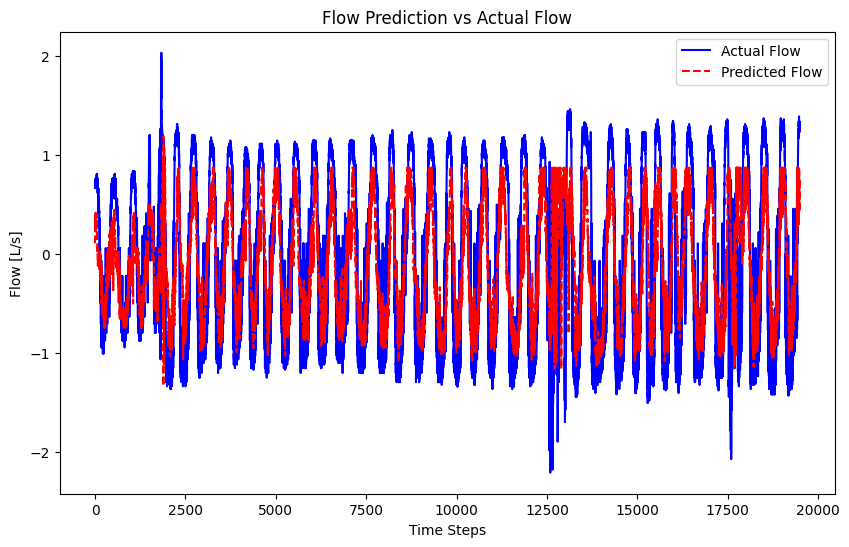

MSE 0.5025885105133057
RMSE 0.7089347716915186


In [23]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_target_arrays[4000:], label='Actual Flow', color='blue')
plt.plot(predictions[4000:], label='Predicted Flow', color='red', linestyle='--')
plt.title('Flow Prediction vs Actual Flow')
plt.xlabel('Time Steps')
plt.ylabel('Flow [L/s]')
plt.legend()
plt.show()

mse = history.history['mse'][-1]

print("MSE", mse)

rmse = np.sqrt(mse)

print("RMSE", rmse)

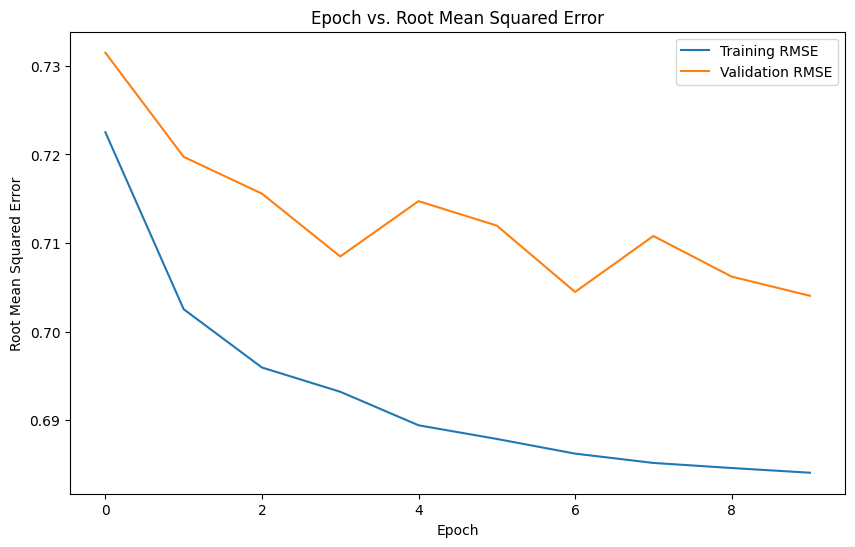

In [10]:
# Access the MSE from the history object
mse = history.history['mse']

# Calculate the RMSE by taking the square root of the MSE
rmse = np.sqrt(mse)

# Optionally, if you have validation MSE, calculate validation RMSE
val_mse = history.history.get('val_mse', None)
if val_mse is not None:
    val_rmse = np.sqrt(val_mse)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(rmse, label='Training RMSE')
if val_mse is not None:
    plt.plot(val_rmse, label='Validation RMSE')
plt.title('Epoch vs. Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()